https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-mamba-and-state

https://arxiv.org/abs/2403.11423

In [121]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.initializers import Constant
import matplotlib.pyplot as plt
import numpy as np

In [122]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


#nomalização dos pixels para 0 e 1
train_images, test_images = train_images / 255.0, test_images / 255.0

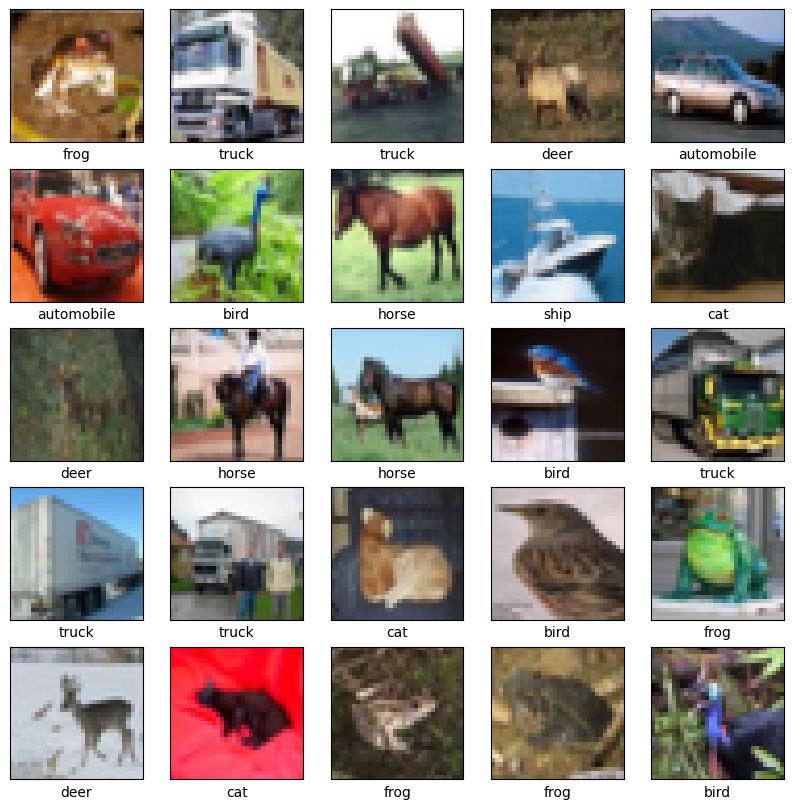

In [123]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[train_labels[i][0]])
plt.show()

# Filtro PID (accuracy + loss + val_accuracy)

In [124]:
#valores de setpoint escolhidos para accuracy, loss e val_accuracy
s_accuracy, s_loss, s_val_accuracy = 1.0, 0.0, 1.0


############################ FILTRO ACCURACY ##############################
erro_ant_A = 0
#valores de setpoint escolhidos para Kp, Ki e Kd
Kp_A       = 1.0
Ki_A       = 0.5
Kd_A       = 0.1
# Termo Proporcional: Foco no centro
kernel_p_A = np.array([[0, 0, 0],
                       [0, 1, 0],
                       [0, 0, 0]], dtype='float32')
# Termo Integral: Média da vizinhança
kernel_i_A = np.ones((3, 3), dtype='float32')
# Termo Derivativo: Gradiente na direção vertical
kernel_d_A = np.array([[-1, -1, -1],
                       [ 0,  0,  0],
                       [ 1,  1,  1]], dtype='float32')
# Combina os kernels com os parâmetros
filtro_PID_A = Kp_A * kernel_p_A + Ki_A * kernel_i_A + Kd_A * kernel_d_A
# Expandindo para 4 dimensões: (altura, largura, canais de entrada, canais de saída)
filtro_PID_A = np.expand_dims(filtro_PID_A, axis=-1)  # Adiciona a dimensão de canais de entrada
filtro_PID_A = np.expand_dims(filtro_PID_A, axis=-1)  # Adiciona a dimensão de canais de saída



############################ FILTRO lOSS ##############################
erro_ant_L = 0
#valores de setpoint escolhidos para Kp, Ki e Kd
Kp_L       = 1.0
Ki_L       = 0.5
Kd_L       = 0.1
# Termo Proporcional: Foco no centro
kernel_p_L = np.array([[0, 0, 0],
                       [0, 1, 0],
                       [0, 0, 0]], dtype='float32')
# Termo Integral: Média da vizinhança
kernel_i_L = np.ones((3, 3), dtype='float32')
# Termo Derivativo: Gradiente na direção vertical
kernel_d_L = np.array([[-1, -1, -1],
                       [ 0,  0,  0],
                       [ 1,  1,  1]], dtype='float32')
# Combina os kernels com os parâmetros
filtro_PID_L = Kp_L * kernel_p_L + Ki_L * kernel_i_L + Kd_L * kernel_d_L
# Expandindo para 4 dimensões: (altura, largura, canais de entrada, canais de saída)
filtro_PID_L = np.expand_dims(filtro_PID_L, axis=-1)  # Adiciona a dimensão de canais de entrada
filtro_PID_L = np.expand_dims(filtro_PID_L, axis=-1)  # Adiciona a dimensão de canais de saída


############################ FILTRO VAL_ACCURACY ##############################
erro_ant_V = 0
#valores de setpoint escolhidos para Kp, Ki e Kd
Kp_V       = 1.0
Ki_V       = 0.5
Kd_V       = 0.1
# Termo Proporcional: Foco no centro
kernel_p_V = np.array([[0, 0, 0],
                       [0, 1, 0],
                       [0, 0, 0]], dtype='float32')
# Termo Integral: Média da vizinhança
kernel_i_V = np.ones((3, 3), dtype='float32')
# Termo Derivativo: Gradiente na direção vertical
kernel_d_V = np.array([[-1, -1, -1],
                       [ 0,  0,  0],
                       [ 1,  1,  1]], dtype='float32')
# Combina os kernels com os parâmetros
filtro_PID_V = Kp_V * kernel_p_V + Ki_V * kernel_i_V + Kd_V * kernel_d_V
# Expandindo para 4 dimensões: (altura, largura, canais de entrada, canais de saída)
filtro_PID_V = np.expand_dims(filtro_PID_V, axis=-1)  # Adiciona a dimensão de canais de entrada
filtro_PID_V = np.expand_dims(filtro_PID_V, axis=-1)  # Adiciona a dimensão de canais de saída

In [125]:
def atualiza_PID_ALV(epoch, logs):
  global Kp_A, Ki_A, Kd_A, erro_ant_A, Kp_L, Ki_L, Kd_L, erro_ant_L, Kp_V, Ki_V, Kd_V, erro_ant_V
  

  # variável de erro
  erro_A = s_accuracy - logs['accuracy']
  erro_L = s_loss - logs['loss']
  erro_V = s_val_accuracy - logs['val_accuracy']
    
  # atualiza o termo derivativo com o erro anterior e um dt escolhido de 0.1 
  Kd_A       += Kd_A * erro_ant_A /  0.1
  Kd_L       += Kd_L * erro_ant_L /  0.1
  Kd_V       += Kd_L * erro_ant_V /  0.1

  # atualiza o erro anterior para a próxima iteração
  erro_ant_A = erro_A
  erro_ant_L = erro_L
  erro_ant_V = erro_V
    
  # atualiza o termo proporcional com o erro atual (set loss - loss atual)
  Kp_A       += Kp_A * erro_A
  Kp_L       += Kp_L * erro_L
  Kp_V       += Kp_V * erro_V
    
  # atualiza o termo integrativo com o erro atual (set loss - loss atual) e um dt escolhido de 0.1
  Ki_A       += Ki_A * erro_A * 0.1
  Ki_L       += Ki_L * erro_L * 0.1
  Ki_V       += Ki_V * erro_V * 0.1


  filtro_PID_A = Kp_A * kernel_p_A + Ki_A * kernel_i_A + Kd_A * kernel_d_A
  filtro_PID_L = Kp_L * kernel_p_L + Ki_L * kernel_i_L + Kd_L * kernel_d_L
  filtro_PID_V = Kp_V * kernel_p_V + Ki_V * kernel_i_V + Kd_V * kernel_d_V

  print("Novos Filtros PID:")
  print(filtro_PID_A, "\n")
  print(filtro_PID_L, "\n")
  print(filtro_PID_V, "\n")

  #print(f"Época {epoch+1}: accuracy={logs['accuracy']}")
  return

# Filtro PID

In [126]:
#valores de setpoint escolhidos para accuracy, loss e val_accuracy
s_accuracy, s_loss, s_val_accuracy = 1.0, 0.0, 1.0


erro_ant = 0

#valores de setpoint escolhidos para Kp, Ki e Kd
Kp       = 1.0
Ki       = 0.5
Kd       = 0.1

# Termo Proporcional: Foco no centro
kernel_p = np.array([[0, 0, 0],
                     [0, 1, 0],
                     [0, 0, 0]], dtype='float32')

# Termo Integral: Média da vizinhança
kernel_i = np.ones((3, 3), dtype='float32')

# Termo Derivativo: Gradiente na direção vertical
kernel_d = np.array([[-1, -1, -1],
                     [ 0,  0,  0],
                     [ 1,  1,  1]], dtype='float32')

# Combina os kernels com os parâmetros
filtro_PID = Kp * kernel_p + Ki * kernel_i + Kd * kernel_d
# Expandindo para 4 dimensões: (altura, largura, canais de entrada, canais de saída)
filtro_PID = np.expand_dims(filtro_PID, axis=-1)  # Adiciona a dimensão de canais de entrada
filtro_PID = np.expand_dims(filtro_PID, axis=-1)  # Adiciona a dimensão de canais de saída

In [127]:
def atualiza_PID(epoch, logs):
  global Kp, Ki, Kd, erro_ant
  print("\n")
  print("Antigos Valores de:")
  print("Kp:", Kp)
  print("Ki:", Ki)
  print("Kd:", Kd, "\n")

  # variável de erro
  erro = s_val_accuracy - logs['val_accuracy']
  # atualiza o termo derivativo com o erro anterior e um dt escolhido de 0.1
  Kd       += Kd * erro_ant /  0.1
  # atualiza o erro anterior para a próxima iteração
  erro_ant = erro
  # atualiza o termo proporcional com o erro atual (set loss - loss atual)
  Kp       += Kp * erro
  # atualiza o termo integrativo com o erro atual (set loss - loss atual) e um dt escolhido de 0.1
  Ki       += Ki * erro * 0.1

  print("Novos Valores de:")
  print("Kp:", Kp)
  print("Ki:", Ki)
  print("Kd:", Kd, "\n")

  filtro_PID = Kp * kernel_p + Ki * kernel_i + Kd * kernel_d

  print("Novo Filtro PID:")
  print(filtro_PID, "\n")

  #print(f"Época {epoch+1}: accuracy={logs['accuracy']}")
  return

# Modelo PID

In [128]:
modelo_PID = models.Sequential()

modelo_PID.add(layers.Conv2D(
    1,  # Número de filtros de saída
    (3, 3),  # Tamanho do filtro
    activation='relu',
    input_shape=(32, 32, 3),  # Dimensão da entrada
    kernel_initializer=Constant(filtro_PID)
))
modelo_PID.add(layers.Conv2D(32, (3, 3), activation='relu'))
modelo_PID.add(layers.MaxPooling2D((2, 2)))
modelo_PID.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_PID.add(layers.MaxPooling2D((2, 2)))
modelo_PID.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [129]:
modelo_PID.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)                   │ (None, 30, 30, 1)           │              28 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,772 (217.86 KB)

 Trainable params: 55,772 (217.86 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
modelo_PID.add(layers.Flatten())
modelo_PID.add(layers.Dense(64, activation='relu'))
modelo_PID.add(layers.Dense(10))

In [131]:
modelo_PID.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)                   │ (None, 30, 30, 1)           │              28 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,022 (476.65 KB)

 Trainable params: 122,022 (476.65 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
modelo_PID.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=atualiza_PID)

historico_PID = modelo_PID.fit(train_images,
                               train_labels,
                               epochs=150,
                               validation_data=(test_images, test_labels),
                               callbacks=[callback])

Epoch 1/150
1553/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3177 - loss: 1.8677

Antigos Valores de:
Kp: 1.0
Ki: 0.5
Kd: 0.1 

Novos Valores de:
Kp: 1.4715999960899353
Ki: 0.5235799998044968
Kd: 0.1 

Novo Filtro PID:
[[0.42358002 0.42358002 0.42358002]
 [0.52358    1.9951801  0.52358   ]
 [0.62358004 0.62358004 0.62358004]] 

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3183 - loss: 1.8661 - val_accuracy: 0.5284 - val_loss: 1.3466
Epoch 2/150
1560/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5530 - loss: 1.2737

Antigos Valores de:
Kp: 1.4715999960899353
Ki: 0.5235799998044968
Kd: 0.1 

Novos Valores de:
Kp: 2.074367383118286
Ki: 0.5450258376151116
Kd: 0.5715999960899353 

Novo Filtro PID:
[[-0.02657419 -0.02657419 -0.02657419]
 [ 0.5450258   2.619393    0.5450258 ]
 [ 1.1166258   1.1166258   1.1166258 ]] 

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5530 - loss: 1.2736 - val_accuracy: 0.5904 - val_loss: 1.1696
Epoch 3/150
1557/1563 ━━━━━━━━━━


# Modelo PID - Trocando primeiro filtro

In [133]:
modelo_PID_sub = models.Sequential()

modelo_PID_sub.add(layers.Conv2D(
    1,  # Número de filtros de saída
    (3, 3),  # Tamanho do filtro
    activation='relu',
    input_shape=(32, 32, 3),  # Dimensão da entrada
    kernel_initializer=Constant(filtro_PID)
))

modelo_PID_sub.add(layers.MaxPooling2D((2, 2)))
modelo_PID_sub.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_PID_sub.add(layers.MaxPooling2D((2, 2)))
modelo_PID_sub.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [134]:
modelo_PID_sub.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)                   │ (None, 30, 30, 1)           │              28 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 15, 15, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 13, 13, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,596 (146.86 KB)

 Trainable params: 37,596 (146.86 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
modelo_PID_sub.add(layers.Flatten())
modelo_PID_sub.add(layers.Dense(64, activation='relu'))
modelo_PID_sub.add(layers.Dense(10))

In [136]:
modelo_PID_sub.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)                   │ (None, 30, 30, 1)           │              28 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 15, 15, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 13, 13, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,846 (405.65 KB)

 Trainable params: 103,846 (405.65 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
modelo_PID_sub.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=atualiza_PID)

historico_PID_sub = modelo_PID_sub.fit(train_images,
                               train_labels,
                               epochs=150,
                               validation_data=(test_images, test_labels),
                               callbacks=[callback])

Epoch 1/150
1552/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2971 - loss: 1.9454

Antigos Valores de:
Kp: 1.1537457395836266e+19
Ki: 75.35637492453846
Kd: 6.774080933593608e+94 

Novos Valores de:
Kp: 1.7863445263417188e+19
Ki: 79.48816494691849
Kd: 3.013111168253155e+95 

Novo Filtro PID:
[[-3.01311117e+95 -3.01311117e+95 -3.01311117e+95]
 [ 7.94881668e+01  1.78634455e+19  7.94881668e+01]
 [ 3.01311117e+95  3.01311117e+95  3.01311117e+95]] 

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2977 - loss: 1.9441 - val_accuracy: 0.4517 - val_loss: 1.5430
Epoch 2/150
1555/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4643 - loss: 1.5158

Antigos Valores de:
Kp: 1.7863445263417188e+19
Ki: 79.48816494691849
Kd: 3.013111168253155e+95 

Novos Valores de:
Kp: 2.6889843894372487e+19
Ki: 83.50470180570338
Kd: 1.9533999644877905e+96 

Novo Filtro PID:
[[-1.95339996e+96 -1.95339996e+96 -1.95339996e+96]
 [ 8.35046997e+01  2.68898433e+19  8.35046997e+01]
 [ 1.95339996e+96  1.953

# Modelo Full PID

In [138]:
modelo_PID_FULL = models.Sequential()

modelo_PID_FULL.add(layers.Conv2D(
    32,  # Número de filtros de saída
    (3, 3),  # Tamanho do filtro
    activation='relu',
    input_shape=(32, 32, 3),  # Dimensão da entrada
    kernel_initializer=Constant(filtro_PID_A)
))

modelo_PID_FULL.add(layers.MaxPooling2D((2, 2)))
modelo_PID_FULL.add(layers.Conv2D(
    64,  # Número de filtros de saída
    (3, 3),  # Tamanho do filtro
    activation='relu',
    kernel_initializer=Constant(filtro_PID_L)
))
modelo_PID_FULL.add(layers.MaxPooling2D((2, 2)))
modelo_PID_FULL.add(layers.Conv2D(
    64,  # Número de filtros de saída
    (3, 3),  # Tamanho do filtro
    activation='relu',
    kernel_initializer=Constant(filtro_PID_V)
))

In [139]:
modelo_PID_FULL.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [140]:
modelo_PID_FULL.add(layers.Flatten())
modelo_PID_FULL.add(layers.Dense(64, activation='relu'))
modelo_PID_FULL.add(layers.Dense(10))

In [141]:
modelo_PID_FULL.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
modelo_PID_FULL.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=atualiza_PID_ALV)

historico_PID_FULL = modelo_PID_FULL.fit(train_images,
                                train_labels,
                                epochs=150,
                                validation_data=(test_images, test_labels),
                                callbacks=[callback])

Epoch 1/150
1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0994 - loss: 51747.1875Novos Filtros PID:
[[0.44505998 0.44505998 0.44505998]
 [0.54506    2.44626    0.54506   ]
 [0.64506    0.64506    0.64506   ]] 

[[  -515.5789    -515.5789    -515.5789 ]
 [  -515.47894 -10834.058     -515.47894]
 [  -515.37897   -515.37897   -515.37897]] 

[[0.44500002 0.44500002 0.44500002]
 [0.545      2.445      0.545     ]
 [0.64500004 0.64500004 0.64500004]] 

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.0994 - loss: 51535.3711 - val_accuracy: 0.1000 - val_loss: 3.3385
Epoch 2/150
1559/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1013 - loss: 3.3025Novos Filtros PID:
[[-0.4070475  -0.4070475  -0.4070475 ]
 [ 0.59415245  4.2077255   0.59415245]
 [ 1.5953524   1.5953524   1.5953524 ]] 

[[  9956.552     9956.552     9956.552  ]
 [  -362.92783  19855.352     -362.92783]
 [-10682.407   -10682.407   -10682.407  ]] 

[[ 9.2875805e+04  9.2875805e+04  9.2875805e+04]
 [ 5.940499

# Modelo sem PID

In [143]:
modelo = models.Sequential()

modelo.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [144]:
modelo.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [145]:
modelo.add(layers.Flatten())
modelo.add(layers.Dense(64, activation='relu'))
modelo.add(layers.Dense(10))

In [146]:
modelo.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
modelo.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

historico = modelo.fit(train_images, train_labels, epochs=150,
                    validation_data=(test_images, test_labels))

Epoch 1/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3429 - loss: 1.7743 - val_accuracy: 0.5278 - val_loss: 1.3148
Epoch 2/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5573 - loss: 1.2390 - val_accuracy: 0.6051 - val_loss: 1.1107
Epoch 3/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6291 - loss: 1.0462 - val_accuracy: 0.6484 - val_loss: 0.9893
Epoch 4/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6746 - loss: 0.9226 - val_accuracy: 0.6517 - val_loss: 0.9827
Epoch 5/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7005 - loss: 0.8486 - val_accuracy: 0.6737 - val_loss: 0.9285
Epoch 6/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7251 - loss: 0.7828 - val_accuracy: 0.6909 - val_loss: 0.8779
Epoch 7/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7472 - loss: 0.7219 - val_accuracy: 0.6773 - val_loss: 0.9352
Epoch 8/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7592 - loss: 0

# Plot

Teste Modelo PID_FULL: 
313/313 - 1s - 2ms/step - accuracy: 0.6552 - loss: 4.9012
0.6552000045776367


Teste Modelo Sem PID : 
313/313 - 1s - 2ms/step - accuracy: 0.6648 - loss: 5.3204
0.6647999882698059




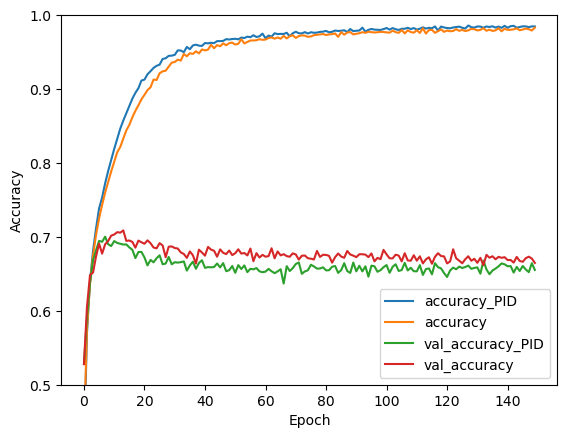

In [148]:
plt.plot(historico_PID.history['accuracy'], label='accuracy_PID')
plt.plot(historico.history['accuracy'], label='accuracy')
plt.plot(historico_PID.history['val_accuracy'], label = 'val_accuracy_PID')
plt.plot(historico.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print("Teste Modelo PID_FULL: ")
test_loss, test_acc = modelo_PID.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)
print("\n")
print("Teste Modelo Sem PID : ")
test_loss, test_acc = modelo.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)
print("\n")